# Encoding Methods on a variational hybrid quantum-classical convolutional neural network

This evaluation jupyter notebook compiles all the experimental results, along with running the baseline vs classical CNN experiment! This compilation of results is done since the training for many of these models require longer than 2 hours.

In [155]:
from glob import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import pennylane as qml
# Just like standard NumPy, but with the added benefit of automatic differentiation
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import cv2
%matplotlib inline

Retrieve the seeds saved from the training information of the models. The seeds are used to generate the random aspects of the models, such as the initial quantum circuit (and its parameters)

In [156]:
def get_seeds(filenames, repeat=50):
    return pd.DataFrame({"Seed": np.array([[int(re.split( "_", filename)[1])]*repeat for filename in filenames]).flatten()})

In [157]:
smoothing_window = 1
fontsize_title = 20
fontsize_axes = 18
fontsize_legend = 14

# 2x2 Kernels on 14x14 MNIST

In [158]:
# load files

filter_size = "2x2"
image_size = "14z14"
path = "./Results/"
plot_path = "plots/" + filter_size + "/"


# Using Glob to read all the training and testing result
efrqi_Variational_files = glob(path + "Seed*yes*EFRQI*/train_result.csv")
efrqi_Baseline_files = glob(path + "Seed*no*EFRQI*/train_result.csv")
test_efrqi_Variational_files = glob(path + "Seed*yes*EFRQI*/test_result.csv")
test_efrqi_Baseline_files = glob(path + "Seed*no*EFRQI*/test_result.csv")

eneqr_Variational_files = glob(path + "Seed*yes*ENEQR*/train_result.csv")
eneqr_Baseline_files = glob(path + "Seed*no*ENEQR*/train_result.csv")
test_eneqr_Variational_files = glob(path + "Seed*yes*ENEQR*/test_result.csv")
test_eneqr_Baseline_files = glob(path + "Seed*no*ENEQR*/test_result.csv")

frqi_Variational_files = glob(path + "Seed*yes_FRQI*/train_result.csv")
frqi_Baseline_files = glob(path + "Seed*no_FRQI*/train_result.csv")
test_frqi_Variational_files = glob(path + "Seed*yes_FRQI*/test_result.csv")
test_frqi_Baseline_files = glob(path + "Seed*no_FRQI*/test_result.csv")

neqr_Variational_files = glob(path + "Seed*yes_NEQR*/train_result.csv")
neqr_Baseline_files = glob(path + "Seed*no_NEQR*/train_result.csv")
test_neqr_Variational_files = glob(path + "Seed*yes_NEQR*/test_result.csv")
test_neqr_Baseline_files = glob(path + "Seed*no_NEQR*/test_result.csv")

threshold_Variational_files = glob(path + "Seed*yes*Threshold*/train_result.csv")
threshold_Baseline_files = glob(path + "Seed*no*Threshold*/train_result.csv")
test_threshold_Variational_files = glob(path + "Seed*yes*Threshold*/test_result.csv")
test_threshold_Baseline_files = glob(path + "Seed*no*Threshold*/test_result.csv")



# print("Number of Variational EFRQI files: ", len(efrqi_Variational_files))
# print("Number of Baseline EFRQI files: ", len(efrqi_Baseline_files))
# print("Number of Variational ENEQR files: ", len(eneqr_Variational_files))
# print("Number of Baseline ENEQR files: ", len(eneqr_Baseline_files))
# print("Number of Variational FRQI files: ", len(frqi_Variational_files))
# print("Number of Baseline FRQI files: ", len(frqi_Baseline_files))
# print("Number of Variational NEQR files: ", len(neqr_Variational_files))
# print("Number of Baseline NEQR files: ", len(neqr_Baseline_files))
# print("Number of Variational Threshold files: ", len(threshold_Variational_files))
# print("Number of Baseline Threshold files: ", len(threshold_Baseline_files))

## Experiment 1

Baseline HQCCNN vs Classical CNN.
For this experimentation, the classical CNN will be run using PyTorch under the default Adam optimiser, and cross entropy loss similar to the HQCCNN. The following code will train a quick classical CNN with the MNIST dataset, following the configurations of the described HQCCN for evaluation.

In [159]:
# Loading the MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Hyperparameters
n_epochs = 50
n_layers = 1
n_train = 10000
n_test = 1000

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# def resize_mnist_tf(images, size=14):
#     return tf.image.resize(images, (size, size))

# train_images = resize_mnist_tf(train_images).numpy() 
# test_images = resize_mnist_tf(test_images).numpy() 


# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Resize to 14x14
# Resize train_images to (14, 14, 1)
train_images_resized = np.array([cv2.resize(image, (14, 14), interpolation=cv2.INTER_AREA) for image in train_images])
train_images_resized = np.expand_dims(train_images_resized, axis=-1)

# Resize test_images to (14, 14, 1)
test_images_resized = np.array([cv2.resize(image, (14, 14), interpolation=cv2.INTER_AREA) for image in test_images])
test_images_resized = np.expand_dims(test_images_resized, axis=-1)

# Add extra dimension (for convolution channels)
train_images = np.array(train_images_resized[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images_resized[..., tf.newaxis], requires_grad=False)

In [160]:
def model():
    """Initializes and returns a Keras model to be trained"""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(14, 14, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])


    model.compile(
        # Learning rate of 0.01
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [161]:
Classical_CNN_model = model()

classical_history = Classical_CNN_model.fit(train_images, train_labels,
                        validation_data=(test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

Epoch 1/50
2500/2500 - 4s - 2ms/step - accuracy: 0.9039 - loss: 0.3111 - val_accuracy: 0.9460 - val_loss: 0.1679
Epoch 2/50
2500/2500 - 3s - 1ms/step - accuracy: 0.9502 - loss: 0.1757 - val_accuracy: 0.9520 - val_loss: 0.1483
Epoch 3/50
2500/2500 - 3s - 1ms/step - accuracy: 0.9576 - loss: 0.1472 - val_accuracy: 0.9460 - val_loss: 0.1941
Epoch 4/50
2500/2500 - 3s - 1ms/step - accuracy: 0.9631 - loss: 0.1274 - val_accuracy: 0.9620 - val_loss: 0.1549
Epoch 5/50
2500/2500 - 3s - 1ms/step - accuracy: 0.9623 - loss: 0.1360 - val_accuracy: 0.9380 - val_loss: 0.2638
Epoch 6/50
2500/2500 - 2s - 994us/step - accuracy: 0.9685 - loss: 0.1191 - val_accuracy: 0.9440 - val_loss: 0.2350
Epoch 7/50
2500/2500 - 2s - 999us/step - accuracy: 0.9699 - loss: 0.1177 - val_accuracy: 0.9590 - val_loss: 0.1817
Epoch 8/50
2500/2500 - 2s - 996us/step - accuracy: 0.9709 - loss: 0.1209 - val_accuracy: 0.9590 - val_loss: 0.1914
Epoch 9/50
2500/2500 - 3s - 1ms/step - accuracy: 0.9719 - loss: 0.1154 - val_accuracy: 0.9

Plotting the evaluations between the just trained classical CNN and the Baseline HQCCNN. In this codebase, the baseline HQCCNN is described as _Baseline_ model with _Threshold_ encoding. 

The Baseline HQCCNN model has been previously trained and the results is compiled from its training results.

32/32 - 0s - 4ms/step - accuracy: 0.9560 - loss: 1.1698


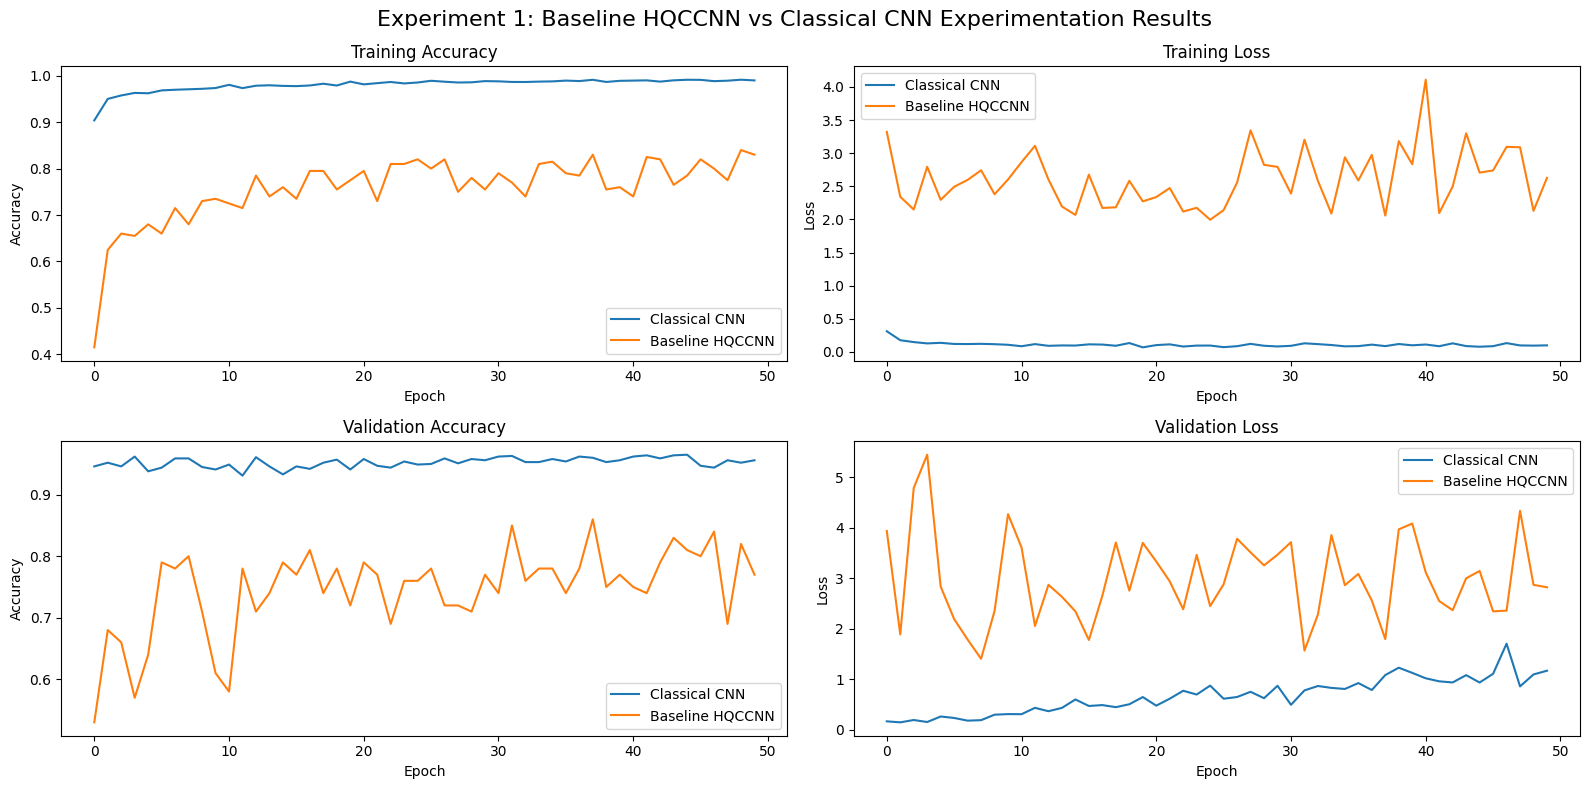

In [162]:
# Test the Classical CNN model
test_loss, test_acc = Classical_CNN_model.evaluate(test_images, test_labels, verbose=2)

# Retrieve the Baseline HQCCNN model training/testing results
threshold_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in threshold_Baseline_files])
threshold_Baseline["Algorithm"] = "Threshold"
threshold_Baseline["QuantumCircuit"] = "Baseline"
threshold_Baseline = threshold_Baseline.reset_index().drop(columns=["index"])
threshold_Baseline["Seed"] = get_seeds(threshold_Baseline_files)

# Extract training accuracy and loss for Classical CNN model
classical_acc = classical_history.history['accuracy']
classical_loss = classical_history.history['loss']

# Extract training accuracy and loss for baseline HQCCNN (threshold_Baseline)
baseline_acc = threshold_Baseline['train_acc'].values
baseline_loss = threshold_Baseline['train_loss'].values

# Set up the figure and axis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Experiment 1: Baseline HQCCNN vs Classical CNN Experimentation Results", fontsize=16)

# Plot training accuracy
ax1.plot(classical_acc, label='Classical CNN')
ax1.plot(baseline_acc, label='Baseline HQCCNN')
ax1.set_title('Training Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training loss
ax2.plot(classical_loss, label='Classical CNN')
ax2.plot(baseline_loss, label='Baseline HQCCNN')
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Extract val accuracy and loss for Classical CNN model
classical_acc = classical_history.history['val_accuracy']
classical_loss = classical_history.history['val_loss']

# Extract training accuracy and loss for baseline HQCCNN (threshold_Baseline)
baseline_acc = threshold_Baseline['val_acc'].values
baseline_loss = threshold_Baseline['val_loss'].values

# Plot training accuracy
ax3.plot(classical_acc, label='Classical CNN')
ax3.plot(baseline_acc, label='Baseline HQCCNN')
ax3.set_title('Validation Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot training loss
ax4.plot(classical_loss, label='Classical CNN')
ax4.plot(baseline_loss, label='Baseline HQCCNN')
ax4.set_title('Validation Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()


# Adjust layout and display the figure
plt.tight_layout()
fig.savefig(plot_path + "Baseline HQCCNN vs Classical CNN.png")

## Compiling Experimentation Data

For the remaining experimentations, we retrieve all the dataset provided from the training and testing results of all the models. The training data of all models will be compiled into `all_data`, and testing data of all models will be compiled into `all_data_test`. 

The remaining experiments and evaluations will utilised these two variables.

In [163]:
eneqr_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in eneqr_Variational_files])
eneqr_Variational["Algorithm"] = "ENEQR"
eneqr_Variational["QuantumCircuit"] = "Variational"
eneqr_Variational = eneqr_Variational.reset_index().drop(columns=["index"])
eneqr_Variational["Seed"] = get_seeds(eneqr_Variational_files)

eneqr_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in eneqr_Baseline_files])
eneqr_Baseline["Algorithm"] = "ENEQR"
eneqr_Baseline["QuantumCircuit"] = "Baseline"
eneqr_Baseline = eneqr_Baseline.reset_index().drop(columns=["index"])
eneqr_Baseline["Seed"] = get_seeds(eneqr_Baseline_files)

efrqi_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in efrqi_Variational_files])
efrqi_Variational["Algorithm"] = "EFRQI"
efrqi_Variational["QuantumCircuit"] = "Variational"
efrqi_Variational = efrqi_Variational.reset_index().drop(columns=["index"])
efrqi_Variational["Seed"] = get_seeds(efrqi_Variational_files)

efrqi_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in efrqi_Baseline_files])
efrqi_Baseline["Algorithm"] = "EFRQI"
efrqi_Baseline["QuantumCircuit"] = "Baseline"
efrqi_Baseline = efrqi_Baseline.reset_index().drop(columns=["index"])
efrqi_Baseline["Seed"] = get_seeds(efrqi_Baseline_files)

frqi_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in frqi_Variational_files])
frqi_Variational["Algorithm"] = "FRQI"
frqi_Variational["QuantumCircuit"] = "Variational"
frqi_Variational = frqi_Variational.reset_index().drop(columns=["index"])
frqi_Variational["Seed"] = get_seeds(frqi_Variational_files)

frqi_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in frqi_Baseline_files])
frqi_Baseline["Algorithm"] = "FRQI"
frqi_Baseline["QuantumCircuit"] = "Baseline"
frqi_Baseline = frqi_Baseline.reset_index().drop(columns=["index"])
frqi_Baseline["Seed"] = get_seeds(frqi_Baseline_files)

neqr_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in neqr_Variational_files])
neqr_Variational["Algorithm"] = "NEQR"
neqr_Variational["QuantumCircuit"] = "Variational"
neqr_Variational = neqr_Variational.reset_index().drop(columns=["index"])
neqr_Variational["Seed"] = get_seeds(neqr_Variational_files)

neqr_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in neqr_Baseline_files])
neqr_Baseline["Algorithm"] = "NEQR"
neqr_Baseline["QuantumCircuit"] = "Baseline"
neqr_Baseline = neqr_Baseline.reset_index().drop(columns=["index"])
neqr_Baseline["Seed"] = get_seeds(neqr_Baseline_files)

threshold_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in threshold_Variational_files])
threshold_Variational["Algorithm"] = "Threshold"
threshold_Variational["QuantumCircuit"] = "Variational"
threshold_Variational = threshold_Variational.reset_index().drop(columns=["index"])
threshold_Variational["Seed"] = get_seeds(threshold_Variational_files)

threshold_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in threshold_Baseline_files])
threshold_Baseline["Algorithm"] = "Threshold"
threshold_Baseline["QuantumCircuit"] = "Baseline"
threshold_Baseline = threshold_Baseline.reset_index().drop(columns=["index"])
threshold_Baseline["Seed"] = get_seeds(threshold_Baseline_files)

all_Variational = pd.concat([eneqr_Variational,efrqi_Variational,frqi_Variational, neqr_Variational, threshold_Variational])
all_Variational = all_Variational.reset_index().drop(columns=["index"])

all_Baseline = pd.concat([eneqr_Baseline, efrqi_Baseline,frqi_Baseline, neqr_Baseline, threshold_Baseline])
all_Baseline = all_Baseline.reset_index().drop(columns=["index"])

all_data = pd.concat([all_Variational, all_Baseline])
all_data = all_data.reset_index().drop(columns=["index"])

In [164]:
test_eneqr_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_eneqr_Variational_files])
test_eneqr_Variational["Algorithm"] = "ENEQR"
test_eneqr_Variational["QuantumCircuit"] = "Variational"
test_eneqr_Variational = test_eneqr_Variational.reset_index().drop(columns=["index"])
test_eneqr_Variational["Seed"] = get_seeds(test_eneqr_Variational_files, repeat=1)

test_eneqr_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_eneqr_Baseline_files])
test_eneqr_Baseline["Algorithm"] = "ENEQR"
test_eneqr_Baseline["QuantumCircuit"] = "Baseline"
test_eneqr_Baseline = test_eneqr_Baseline.reset_index().drop(columns=["index"])
test_eneqr_Baseline["Seed"] = get_seeds(test_eneqr_Baseline_files, repeat=1)

test_efrqi_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_efrqi_Variational_files])
test_efrqi_Variational["Algorithm"] = "EFRQI"
test_efrqi_Variational["QuantumCircuit"] = "Variational"
test_efrqi_Variational = test_efrqi_Variational.reset_index().drop(columns=["index"])
test_efrqi_Variational["Seed"] = get_seeds(test_efrqi_Variational_files, repeat=1)

test_efrqi_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_efrqi_Baseline_files])
test_efrqi_Baseline["Algorithm"] = "EFRQI"
test_efrqi_Baseline["QuantumCircuit"] = "Baseline"
test_efrqi_Baseline = test_efrqi_Baseline.reset_index().drop(columns=["index"])
test_efrqi_Baseline["Seed"] = get_seeds(test_efrqi_Baseline_files, repeat=1)

test_frqi_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_frqi_Variational_files])
test_frqi_Variational["Algorithm"] = "FRQI"
test_frqi_Variational["QuantumCircuit"] = "Variational"
test_frqi_Variational = test_frqi_Variational.reset_index().drop(columns=["index"])
test_frqi_Variational["Seed"] = get_seeds(test_frqi_Variational_files, repeat=1)

test_frqi_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_frqi_Baseline_files])
test_frqi_Baseline["Algorithm"] = "FRQI"
test_frqi_Baseline["QuantumCircuit"] = "Baseline"
test_frqi_Baseline = test_frqi_Baseline.reset_index().drop(columns=["index"])
test_frqi_Baseline["Seed"] = get_seeds(test_frqi_Baseline_files, repeat=1)

test_neqr_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_neqr_Variational_files])
test_neqr_Variational["Algorithm"] = "NEQR"
test_neqr_Variational["QuantumCircuit"] = "Variational"
test_neqr_Variational = test_neqr_Variational.reset_index().drop(columns=["index"])
test_neqr_Variational["Seed"] = get_seeds(test_neqr_Variational_files, repeat=1)

test_neqr_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_neqr_Baseline_files])
test_neqr_Baseline["Algorithm"] = "NEQR"
test_neqr_Baseline["QuantumCircuit"] = "Baseline"
test_neqr_Baseline = test_neqr_Baseline.reset_index().drop(columns=["index"])
test_neqr_Baseline["Seed"] = get_seeds(test_neqr_Baseline_files, repeat=1)

test_threshold_Variational = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_threshold_Variational_files])
test_threshold_Variational["Algorithm"] = "Threshold"
test_threshold_Variational["QuantumCircuit"] = "Variational"
test_threshold_Variational = test_threshold_Variational.reset_index().drop(columns=["index"])
test_threshold_Variational["Seed"] = get_seeds(test_threshold_Variational_files, repeat=1)

test_threshold_Baseline = pd.concat([pd.read_csv(filepath_or_buffer=f) for f in test_threshold_Baseline_files])
test_threshold_Baseline["Algorithm"] = "Threshold"
test_threshold_Baseline["QuantumCircuit"] = "Baseline"
test_threshold_Baseline = test_threshold_Baseline.reset_index().drop(columns=["index"])
test_threshold_Baseline["Seed"] = get_seeds(test_threshold_Baseline_files, repeat=1)

test_all_Variational = pd.concat([test_eneqr_Variational, test_efrqi_Variational, test_frqi_Variational, test_neqr_Variational, test_threshold_Variational])
test_all_Variational = test_all_Variational.reset_index().drop(columns=["index"])

test_all_Baseline = pd.concat([test_eneqr_Baseline, test_efrqi_Baseline ,test_frqi_Baseline, test_neqr_Baseline, test_threshold_Baseline])
test_all_Baseline = test_all_Baseline.reset_index().drop(columns=["index"])

test_all_data = pd.concat([test_all_Variational, test_all_Baseline])
test_all_data = test_all_data.reset_index().drop(columns=["index"])

## General Overview Data
Mean train and validation accuracy over the last 25 epochs of all models.

In [165]:

all_data[all_data.epoch > all_data.epoch.max()-25].groupby(["Algorithm","QuantumCircuit"])[["train_acc", "val_acc"]].agg(["mean", "max", "var"])

train_acc                  val_acc                
                              mean    max       var    mean   max       var
Algorithm QuantumCircuit                                                   
EFRQI     Baseline          0.8342  0.925  0.001191  0.8224  0.93  0.002261
          Variational       0.8668  0.915  0.000796  0.8472  0.91  0.001313
ENEQR     Baseline          0.8086  0.880  0.001164  0.8004  0.89  0.002987
          Variational       0.8676  0.930  0.001182  0.8528  0.90  0.000804
FRQI      Baseline          0.7460  0.835  0.002071  0.7552  0.86  0.004401
          Variational       0.7944  0.885  0.001592  0.8148  0.89  0.001951
NEQR      Baseline          0.7634  0.845  0.001352  0.7848  0.87  0.002809
          Variational       0.7692  0.860  0.002129  0.7784  0.87  0.002447
Threshold Baseline          0.7900  0.840  0.000925  0.7740  0.86  0.001958
          Variational       0.7874  0.835  0.000738  0.7868  0.88  0.002831

In [166]:
test_all_data.groupby(["Algorithm","QuantumCircuit"])[["test_acc", ]].agg(["mean", "max"])

test_acc       
                             mean    max
Algorithm QuantumCircuit                
EFRQI     Baseline          0.878  0.878
          Variational       0.891  0.891
ENEQR     Baseline          0.808  0.808
          Variational       0.895  0.895
FRQI      Baseline          0.752  0.752
          Variational       0.802  0.802
NEQR      Baseline          0.811  0.811
          Variational       0.812  0.812
Threshold Baseline          0.847  0.847
          Variational       0.808  0.808

In [167]:
# training time per step
training_times = (all_data.groupby(["Algorithm","QuantumCircuit"])[["train_time_per_step" ]].agg(["mean"])*100*50/60/60) # in hours
training_times.rename(columns={'mean': '(Training Time in Hours)'})
# Calculate the overall percentage increase of the training time for the Variational Quantum Circuit compared to the Standard Quantum Circuit
21.59
37.96
16
40
45

45

## Experiment 2: Variational vs Baseline
In the second experiment category, this dissertation looks towards understanding the main advantage the variational approach of HQCCNN provides. By providing an initial overivew of both apporach's training and validation accuracy. Proceeding with describing results specific to each encoding method.

### Overview Baseline vs Variational Training Accuracy

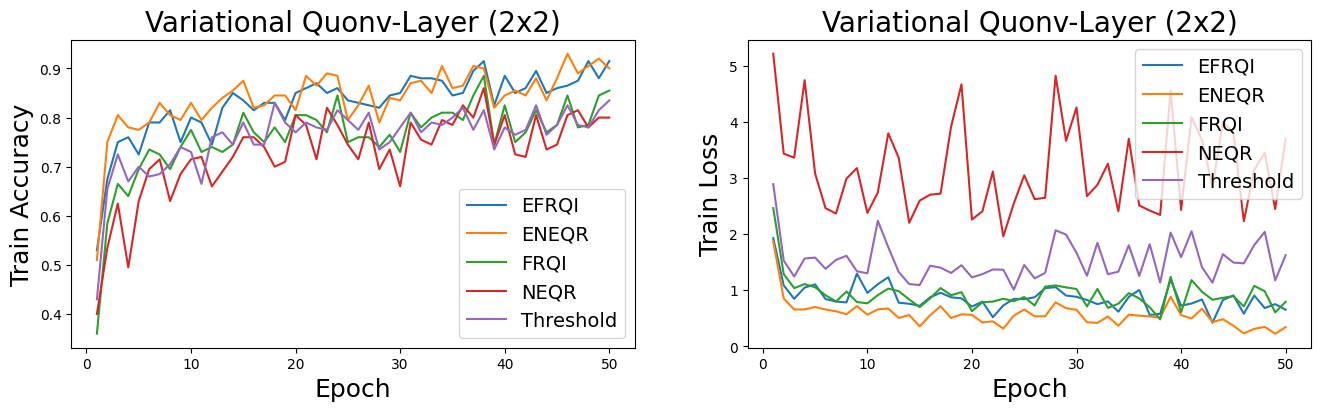

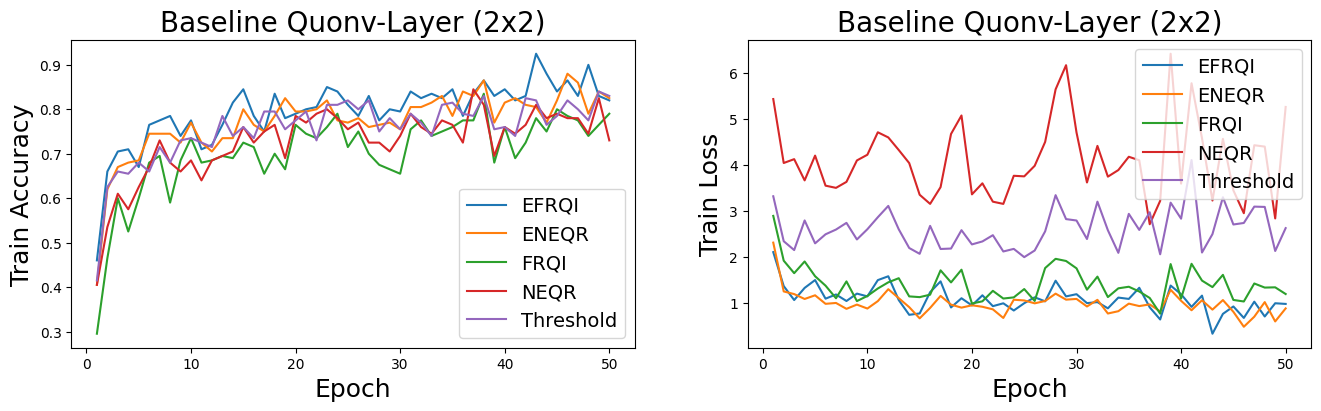

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
data = data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

ax1.set_title("Variational Quonv-Layer (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

ax2.set_title("Variational Quonv-Layer (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "all_algorithms_2x2_Variational_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

data = all_Baseline.drop(columns=["QuantumCircuit"], inplace=False)
data = data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

ax1.set_title("Baseline Quonv-Layer (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

ax2.set_title("Baseline Quonv-Layer (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "all_algorithms_2x2_Baseline_train_acc.png")

### Overview Baseline vs Variational Validation Accuracy

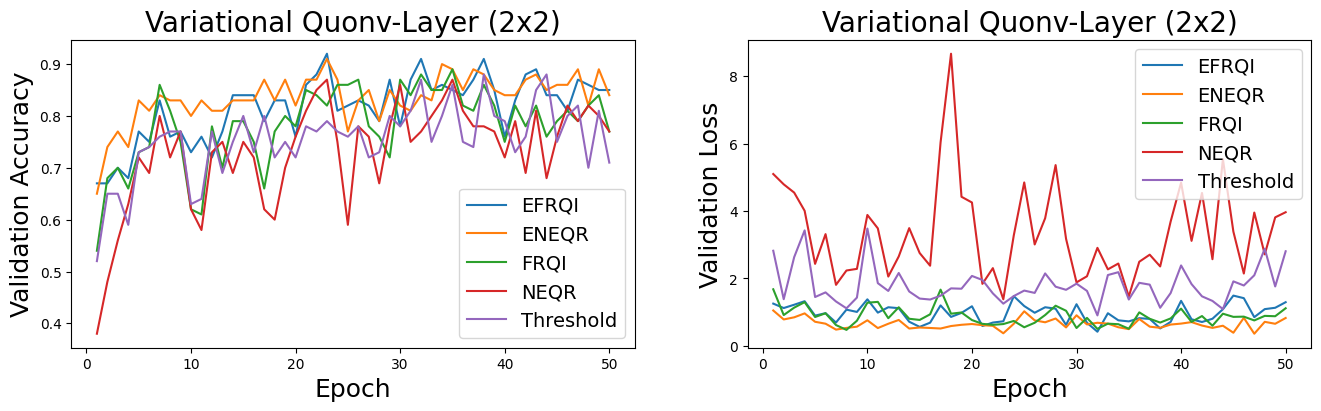

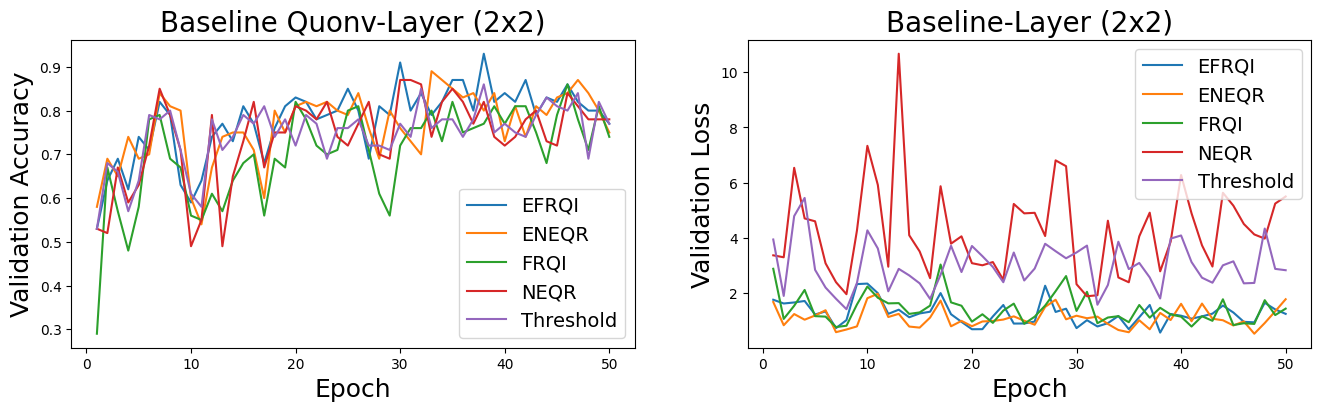

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
data = data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=data, x="epoch", y="val_acc", hue="Algorithm", ax=ax1)

ax1.set_title("Variational Quonv-Layer (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=data, x="epoch", y="val_loss", hue="Algorithm", ax=ax2)

ax2.set_title("Variational Quonv-Layer (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)

fig.savefig(plot_path + "all_algorithms_2x2_Variational_val_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

data = all_Baseline.drop(columns=["QuantumCircuit"], inplace=False)
data = data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=data, x="epoch", y="val_acc", hue="Algorithm", ax=ax1)

ax1.set_title("Baseline Quonv-Layer (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=data, x="epoch", y="val_loss", hue="Algorithm", ax=ax2)

ax2.set_title("Baseline-Layer (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "all_algorithms_2x2_Baseline_val_acc.png")

### EFRQI Variational vs Baseline

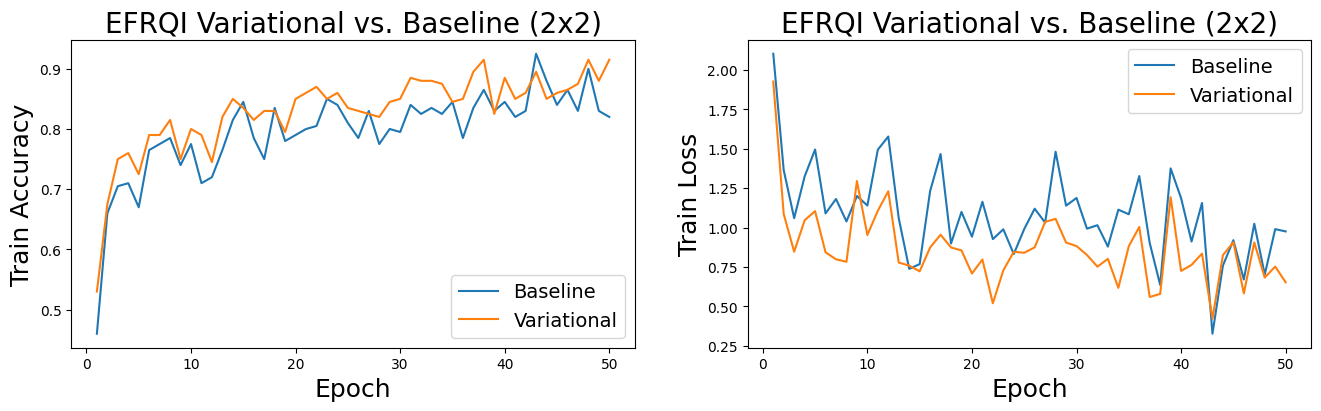

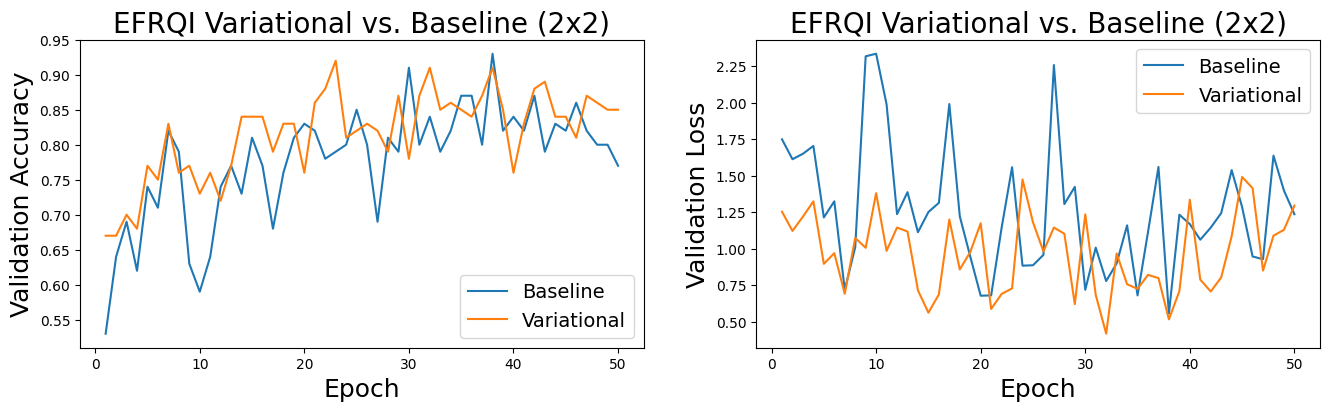

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

efrqi_data = pd.concat([efrqi_Variational, efrqi_Baseline]).drop(columns=["Algorithm"], inplace=False)
efrqi_data = efrqi_data.groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=efrqi_data, x="epoch", y="train_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("EFRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=efrqi_data, x="epoch", y="train_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("EFRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "EFRQI_Variational_vs_Baseline_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

#data = pd.concat([frqi_Variational, frqi_Baseline]).groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()


ax1 = sns.lineplot(data=efrqi_data, x="epoch", y="val_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("EFRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=efrqi_data, x="epoch", y="val_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("EFRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "EFRQI_Variational_vs_Baseline_val_acc.png")

### ENEQR Variational vs Baseline

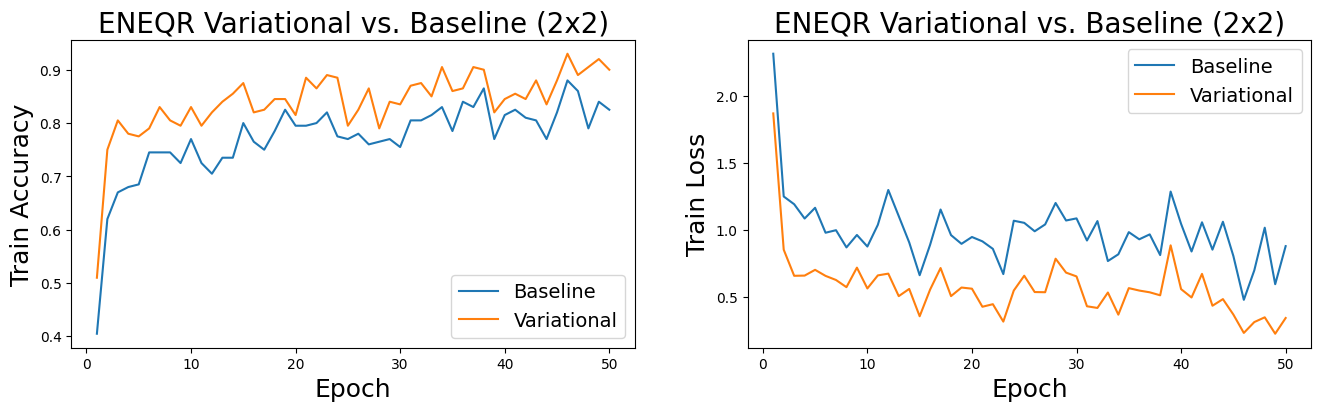

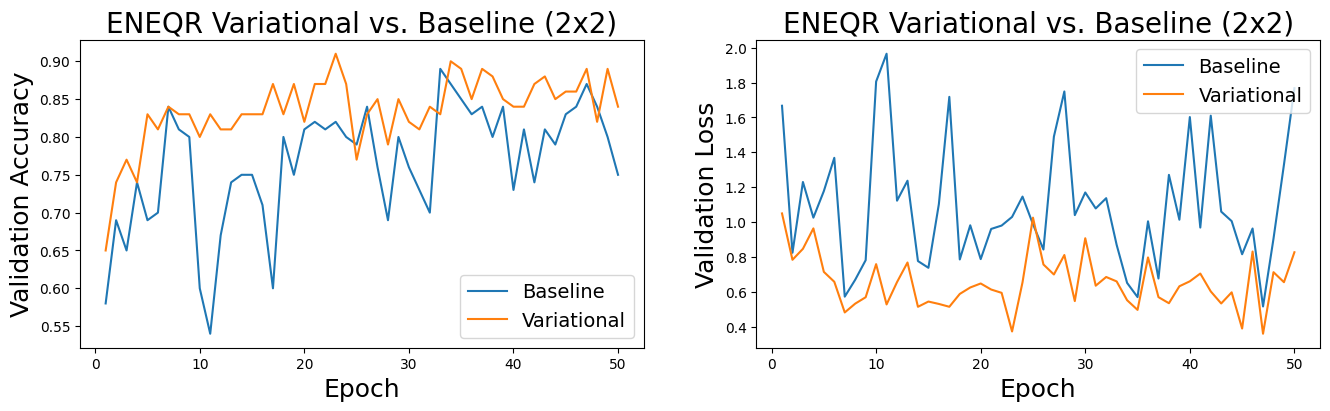

In [171]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

eneqr_data = pd.concat([eneqr_Variational, eneqr_Baseline]).drop(columns=["Algorithm"], inplace=False)
eneqr_data = eneqr_data.groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=eneqr_data, x="epoch", y="train_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("ENEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=eneqr_data, x="epoch", y="train_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("ENEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "ENEQR_Variational_vs_Baseline_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

#data = pd.concat([frqi_Variational, frqi_Baseline]).groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()


ax1 = sns.lineplot(data=eneqr_data, x="epoch", y="val_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("ENEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=eneqr_data, x="epoch", y="val_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("ENEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "ENEQR_Variational_vs_Baseline_val_acc.png")

### FRQI Variational vs Baseline

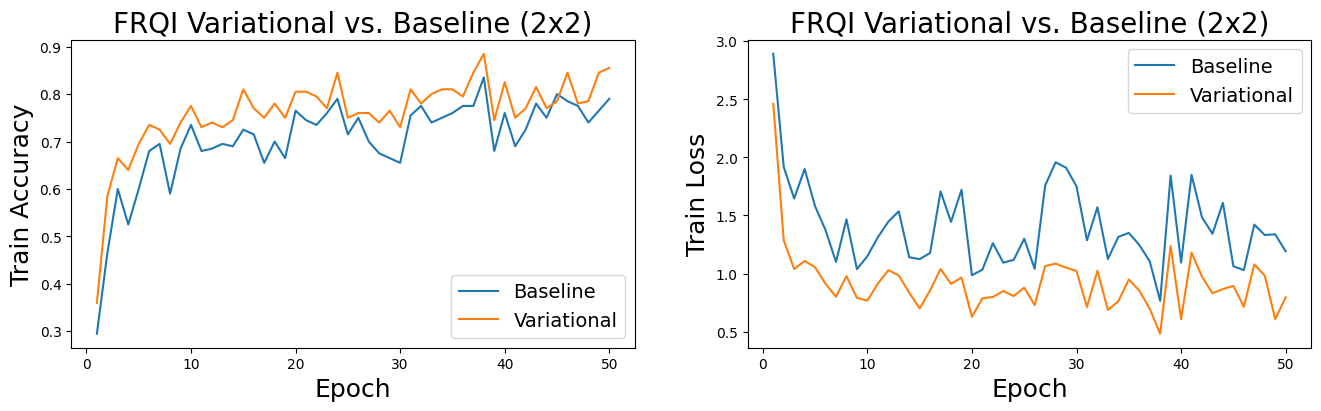

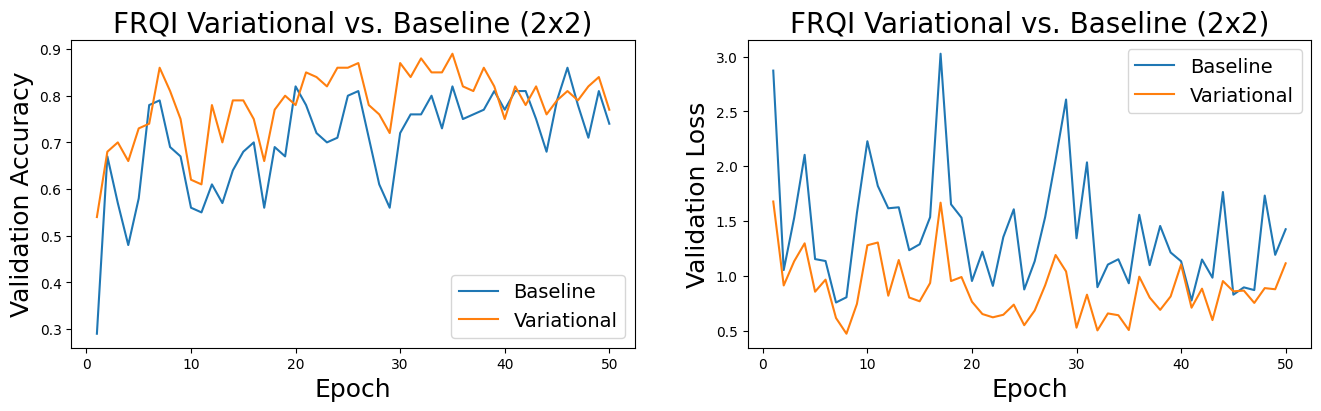

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

frqi_data = pd.concat([frqi_Variational, frqi_Baseline]).drop(columns=["Algorithm"], inplace=False)
frqi_data = frqi_data.groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=frqi_data, x="epoch", y="train_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("FRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=frqi_data, x="epoch", y="train_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("FRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "FRQI_Variational_vs_Baseline_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

#data = pd.concat([frqi_Variational, frqi_Baseline]).groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()


ax1 = sns.lineplot(data=frqi_data, x="epoch", y="val_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("FRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=frqi_data, x="epoch", y="val_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("FRQI Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "FRQI_Variational_vs_Baseline_val_acc.png")

### NEQR Variational vs Baseline

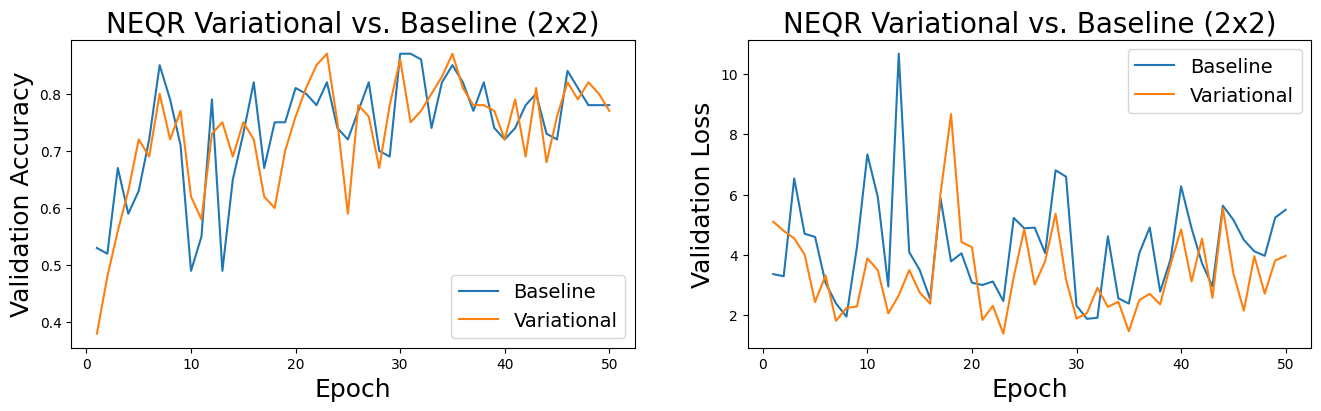

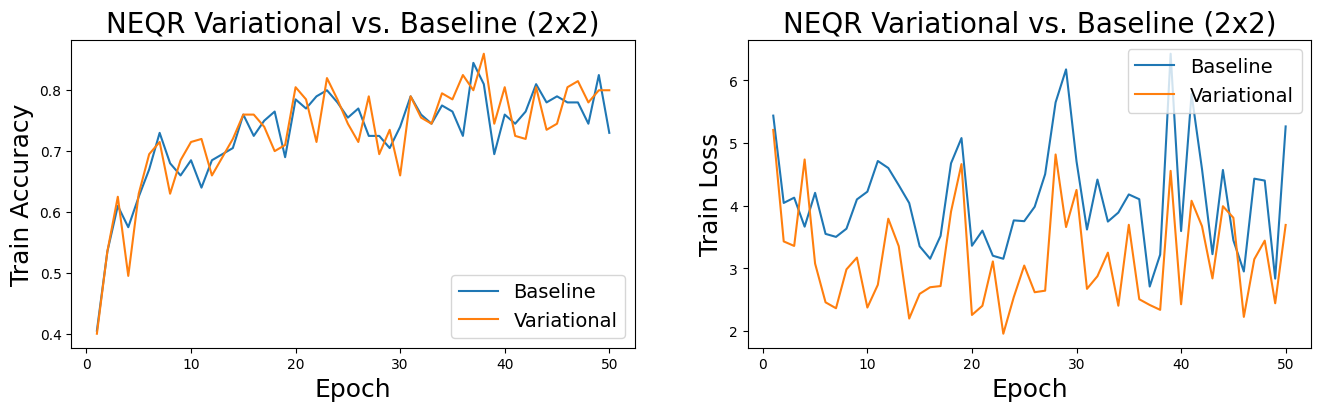

In [173]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

neqr_data = pd.concat([neqr_Variational, neqr_Baseline]).drop(columns=["Algorithm"], inplace=False)
neqr_data = neqr_data.groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=neqr_data, x="epoch", y="val_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("NEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=neqr_data, x="epoch", y="val_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("NEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "NEQR_Variational_vs_Baseline_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1 = sns.lineplot(data=neqr_data, x="epoch", y="train_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("NEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=neqr_data, x="epoch", y="train_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("NEQR Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "NEQR_Variational_vs_Baseline_val_acc.png")

### Threshold Variational vs Baseline

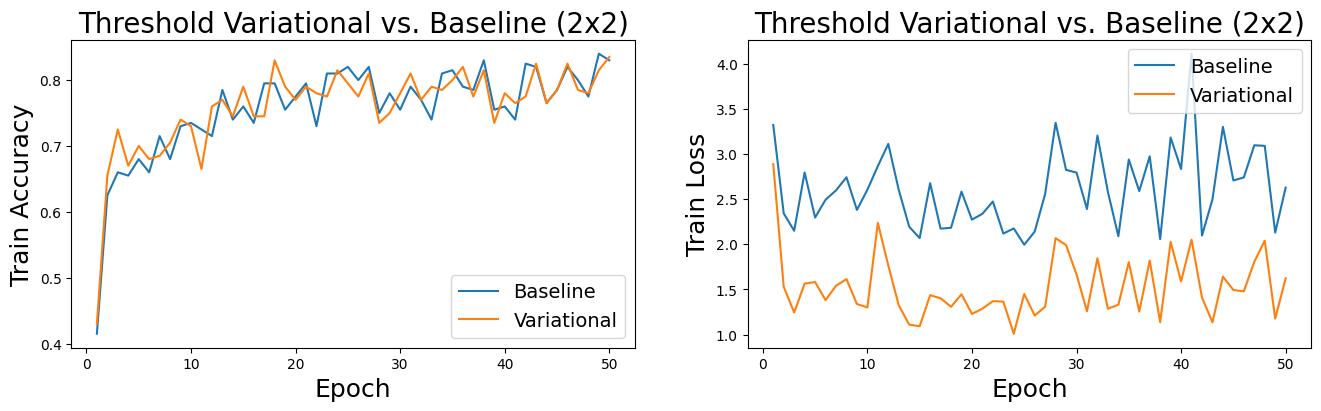

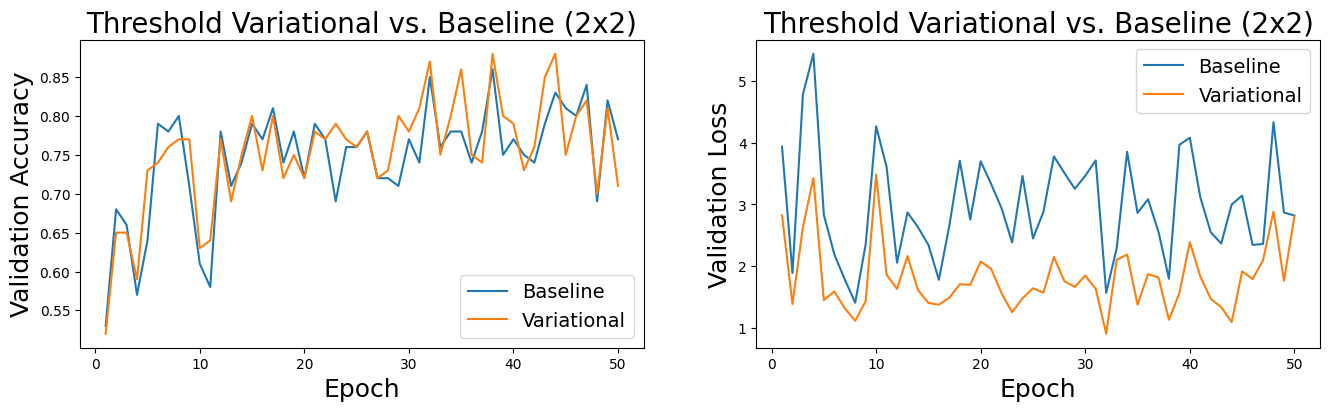

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

thresh_data = pd.concat([threshold_Variational, threshold_Baseline]).drop(columns=["Algorithm"], inplace=False)
thresh_data = thresh_data.groupby(["QuantumCircuit", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=thresh_data, x="epoch", y="train_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("Threshold Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=thresh_data, x="epoch", y="train_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("Threshold Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "ThresholdEncoder_Variational_vs_Baseline_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1 = sns.lineplot(data=thresh_data, x="epoch", y="val_acc", hue="QuantumCircuit", ax=ax1)

ax1.set_title("Threshold Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=thresh_data, x="epoch", y="val_loss", hue="QuantumCircuit", ax=ax2)

ax2.set_title("Threshold Variational vs. Baseline (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "ThresholdEncoder_Variational_vs_Baseline_val_acc.png")

## Experiment 3: Individual Encoding Methods Comparison for a Variational HQCCNN
For the validation encoding methods, ideally there be 10 seeds to discuss varying implementations for encoding however due to time constraints, the methods will be compared one-to-one with a single seed implementation. The below result intends to showcase the best encoding method for a variational HQCCNN. 

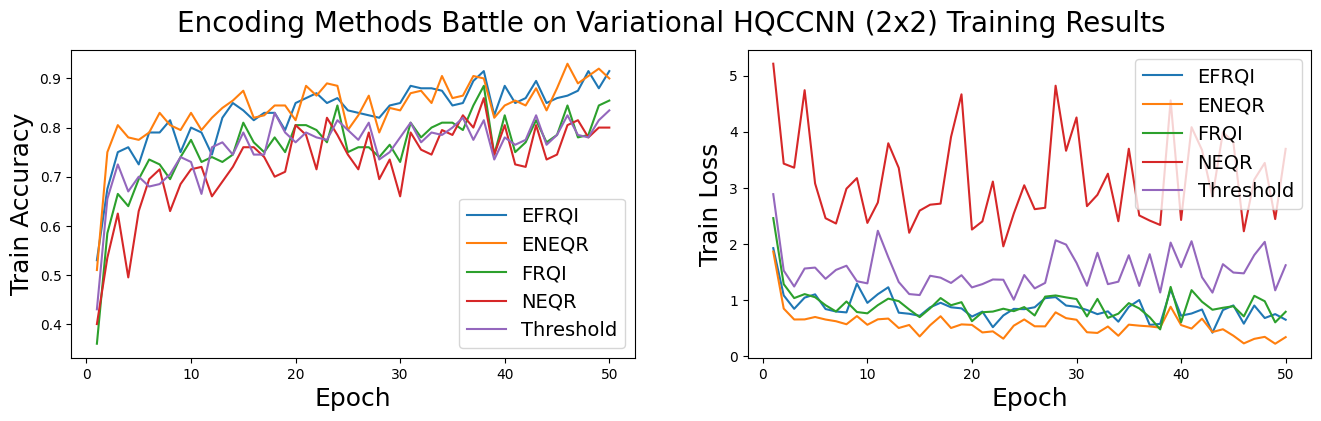

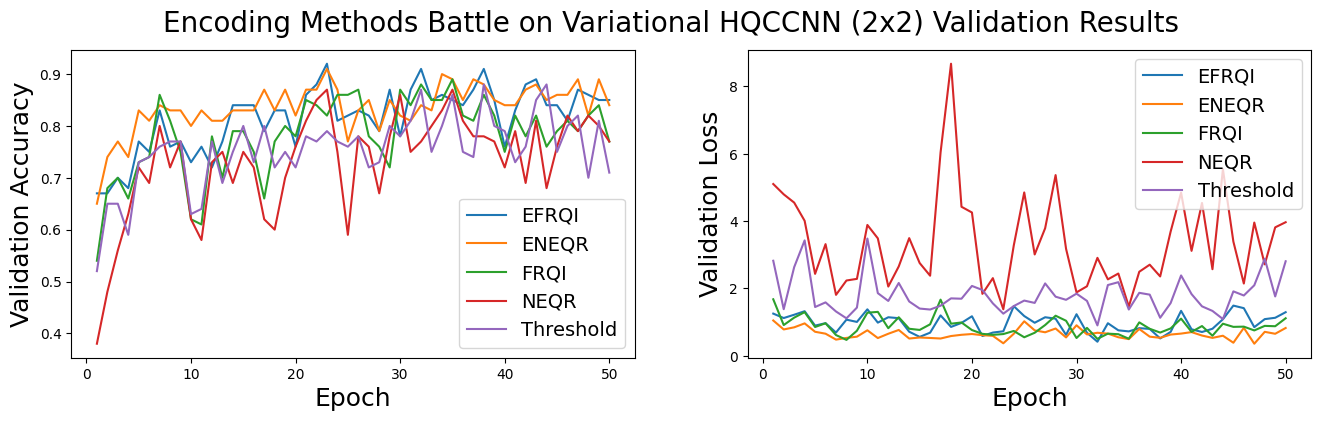

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle("Encoding Methods Battle on Variational HQCCNN (2x2) Training Results", fontsize=fontsize_title)
variational_data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
variational_data = variational_data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=variational_data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=variational_data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "Encoding_Methods_Battle_on_Variational_train_acc.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle("Encoding Methods Battle on Variational HQCCNN (2x2) Validation Results", fontsize=fontsize_title)
ax1 = sns.lineplot(data=variational_data, x="epoch", y="val_acc", hue="Algorithm", ax=ax1)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=variational_data, x="epoch", y="val_loss", hue="Algorithm", ax=ax2)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "Encoding_Methods_Battle_on_Variational_val_acc.png")

### Threshold, FRQI and NEQR

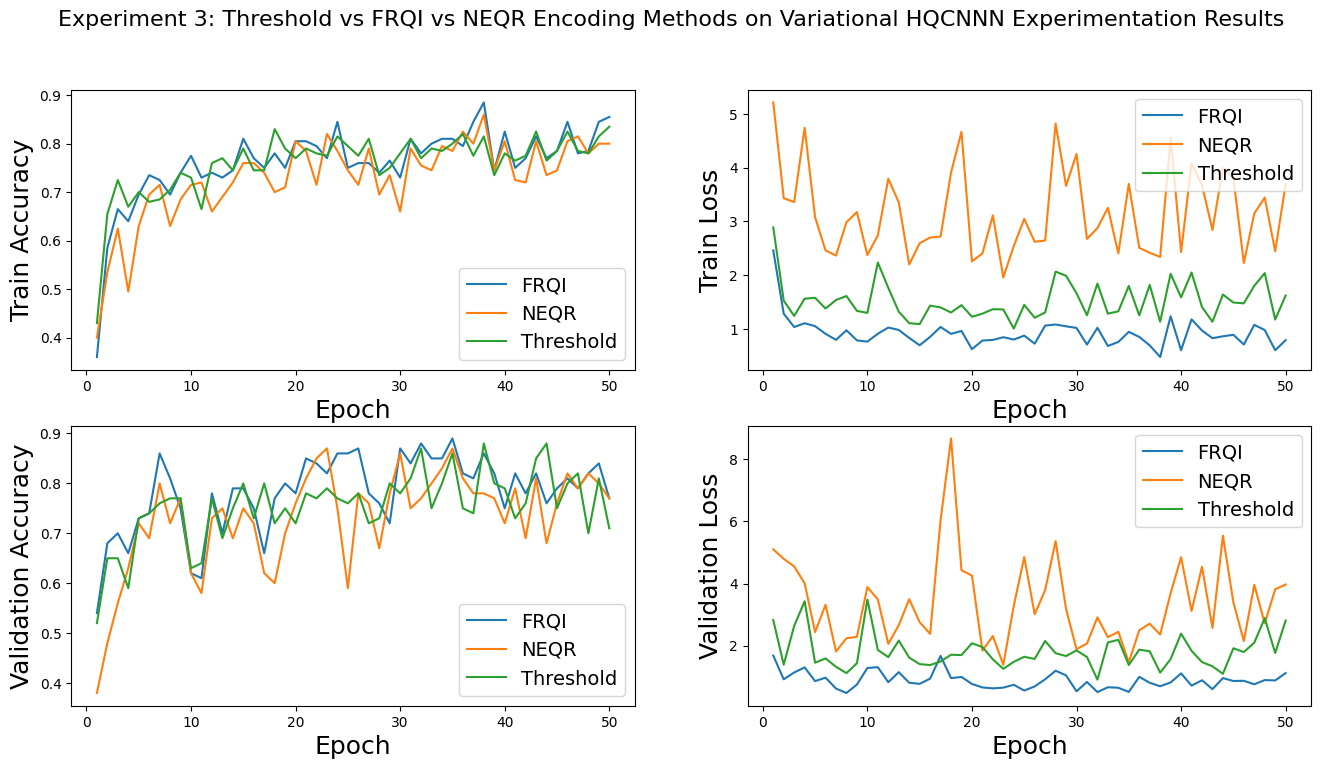

In [176]:
# Set up the figure and axis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Experiment 3: Threshold vs FRQI vs NEQR Encoding Methods on Variational HQCNNN Experimentation Results", fontsize=16)
variational_data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
# Remove EFRQI and ENEQR
variational_data = variational_data[variational_data.Algorithm != "EFRQI"]
variational_data = variational_data[variational_data.Algorithm != "ENEQR"]

variational_data = variational_data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=variational_data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=variational_data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)

ax3 = sns.lineplot(data=variational_data, x="epoch", y="val_acc", hue="Algorithm", ax=ax3)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax3.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax3.set_xlabel("Epoch", fontsize=fontsize_axes)
ax3.legend(loc="lower right", fontsize=fontsize_legend)

ax4 = sns.lineplot(data=variational_data, x="epoch", y="val_loss", hue="Algorithm", ax=ax4)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax4.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax4.set_xlabel("Epoch", fontsize=fontsize_axes)
ax4.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "Experiment 3: Threshold vs FRQI vs NEQR Encoding Methods on Variational HQCNNN Experimentation Results.png")

### EFRQI vs FRQI

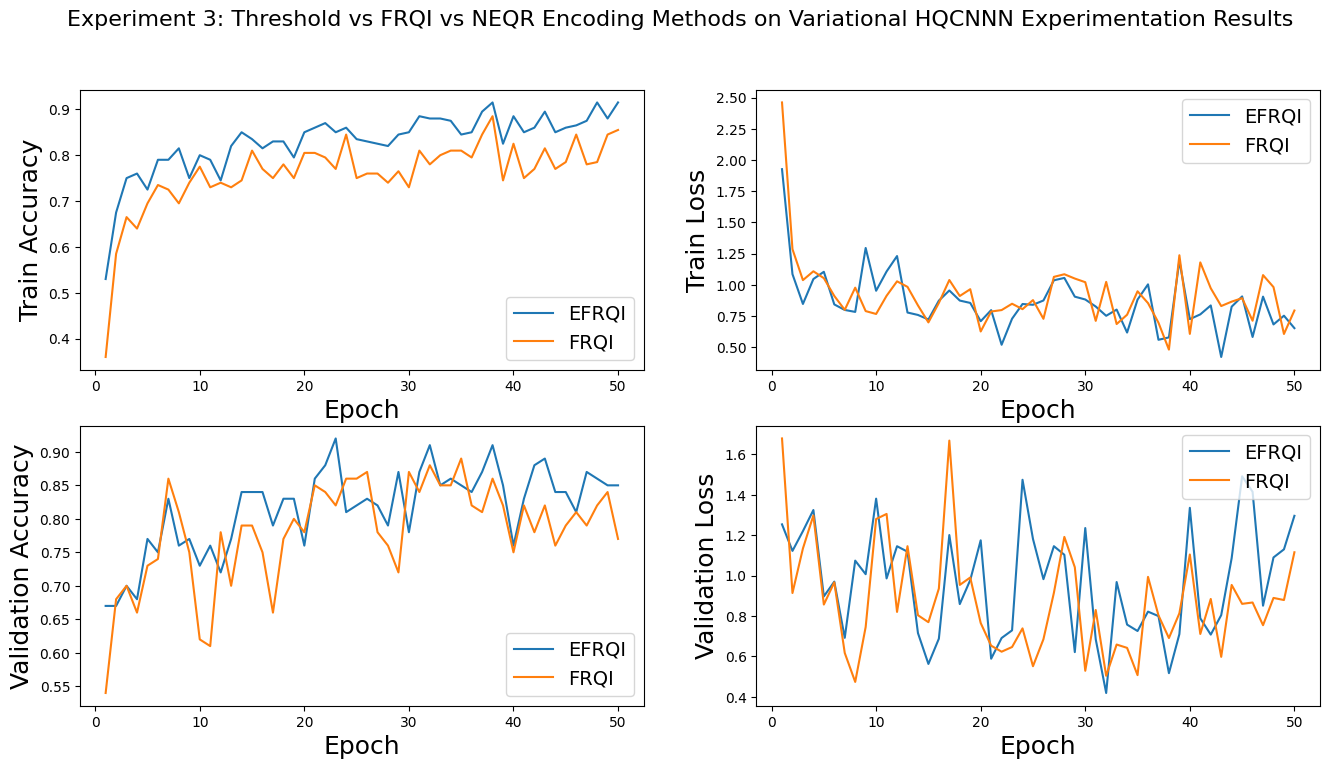

In [177]:
# Set up the figure and axis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Experiment 3: Threshold vs FRQI vs NEQR Encoding Methods on Variational HQCNNN Experimentation Results", fontsize=16)
variational_data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
# Focus on EFRQI and FRQI
variational_data = variational_data[variational_data.Algorithm != "Threshold"]
variational_data = variational_data[variational_data.Algorithm != "NEQR"]
variational_data = variational_data[variational_data.Algorithm != "ENEQR"]

variational_data = variational_data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=variational_data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=variational_data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)

ax3 = sns.lineplot(data=variational_data, x="epoch", y="val_acc", hue="Algorithm", ax=ax3)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax3.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax3.set_xlabel("Epoch", fontsize=fontsize_axes)
ax3.legend(loc="lower right", fontsize=fontsize_legend)

ax4 = sns.lineplot(data=variational_data, x="epoch", y="val_loss", hue="Algorithm", ax=ax4)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax4.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax4.set_xlabel("Epoch", fontsize=fontsize_axes)
ax4.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "Experiment 3: EFRQI vs FRQI Encoding Methods on Variational HQCNNN Experimentation Results.png")

### ENEQR vs NEQR

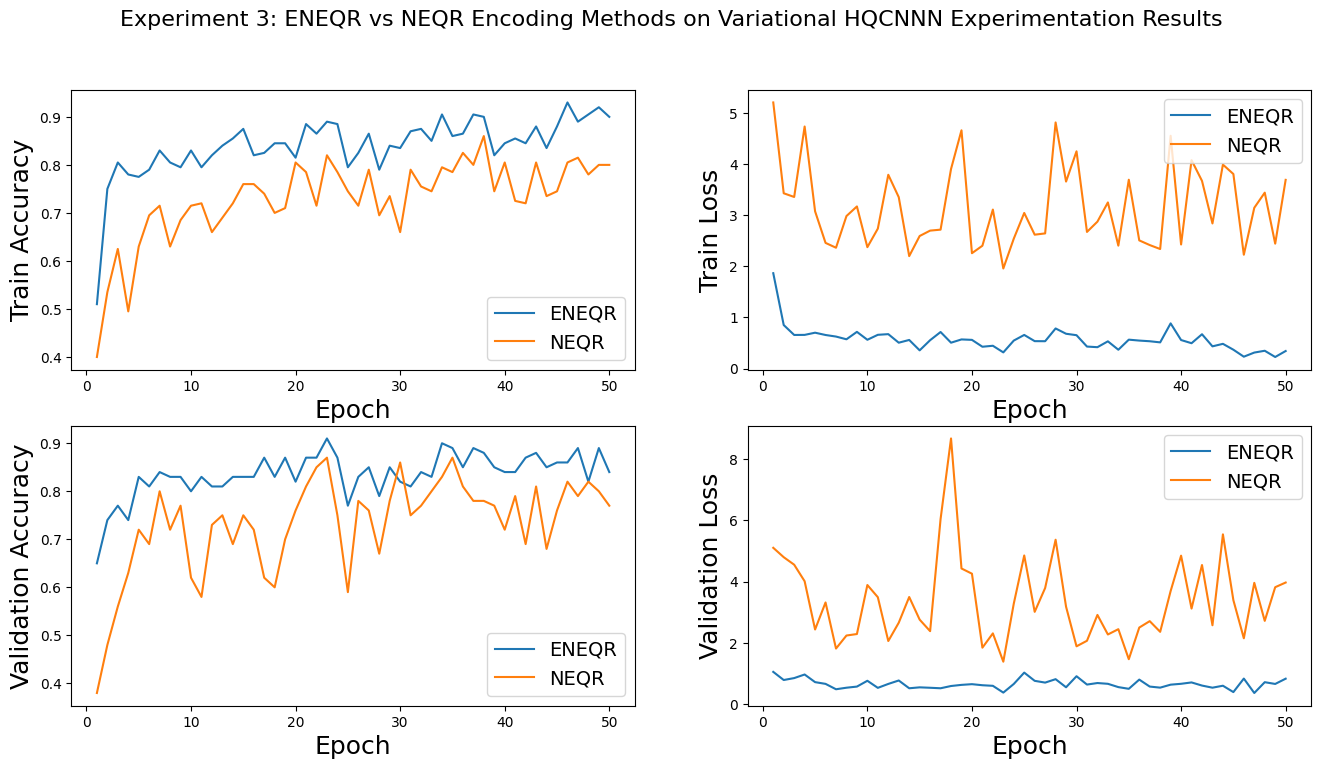

In [178]:
# Set up the figure and axis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Experiment 3: ENEQR vs NEQR Encoding Methods on Variational HQCNNN Experimentation Results", fontsize=16)
variational_data = all_Variational.drop(columns=["QuantumCircuit"], inplace=False)
# Focus on EFRQI and FRQI
variational_data = variational_data[variational_data.Algorithm != "Threshold"]
variational_data = variational_data[variational_data.Algorithm != "FRQI"]
variational_data = variational_data[variational_data.Algorithm != "EFRQI"]

variational_data = variational_data.groupby(["Algorithm", "Seed"]).rolling(window=smoothing_window).mean().dropna()

ax1 = sns.lineplot(data=variational_data, x="epoch", y="train_acc", hue="Algorithm", ax=ax1)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax1.set_ylabel("Train Accuracy", fontsize=fontsize_axes)
ax1.set_xlabel("Epoch", fontsize=fontsize_axes)
ax1.legend(loc="lower right", fontsize=fontsize_legend)


ax2 = sns.lineplot(data=variational_data, x="epoch", y="train_loss", hue="Algorithm", ax=ax2)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN (2x2)", fontsize=fontsize_title)
ax2.set_ylabel("Train Loss", fontsize=fontsize_axes)
ax2.set_xlabel("Epoch", fontsize=fontsize_axes)
ax2.legend(loc="upper right", fontsize=fontsize_legend)

ax3 = sns.lineplot(data=variational_data, x="epoch", y="val_acc", hue="Algorithm", ax=ax3)

#ax1.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax3.set_ylabel("Validation Accuracy", fontsize=fontsize_axes)
ax3.set_xlabel("Epoch", fontsize=fontsize_axes)
ax3.legend(loc="lower right", fontsize=fontsize_legend)

ax4 = sns.lineplot(data=variational_data, x="epoch", y="val_loss", hue="Algorithm", ax=ax4)

#ax2.set_title("Encoding Methods Battle on Variational HQCCNN  (2x2)", fontsize=fontsize_title)
ax4.set_ylabel("Validation Loss", fontsize=fontsize_axes)
ax4.set_xlabel("Epoch", fontsize=fontsize_axes)
ax4.legend(loc="upper right", fontsize=fontsize_legend)


fig.savefig(plot_path + "Experiment 3: ENEQR vs NEQR Encoding Methods on Variational HQCNNN Experimentation Results.png")

## Extras

### Comparing Classical CNN vs the ENEQR HQCCNN (Best Quality Variational HQCCNN)

32/32 - 0s - 2ms/step - accuracy: 0.9560 - loss: 1.1698
1.1697760820388794 0.9559999704360962
[0.895] [0.40555729]


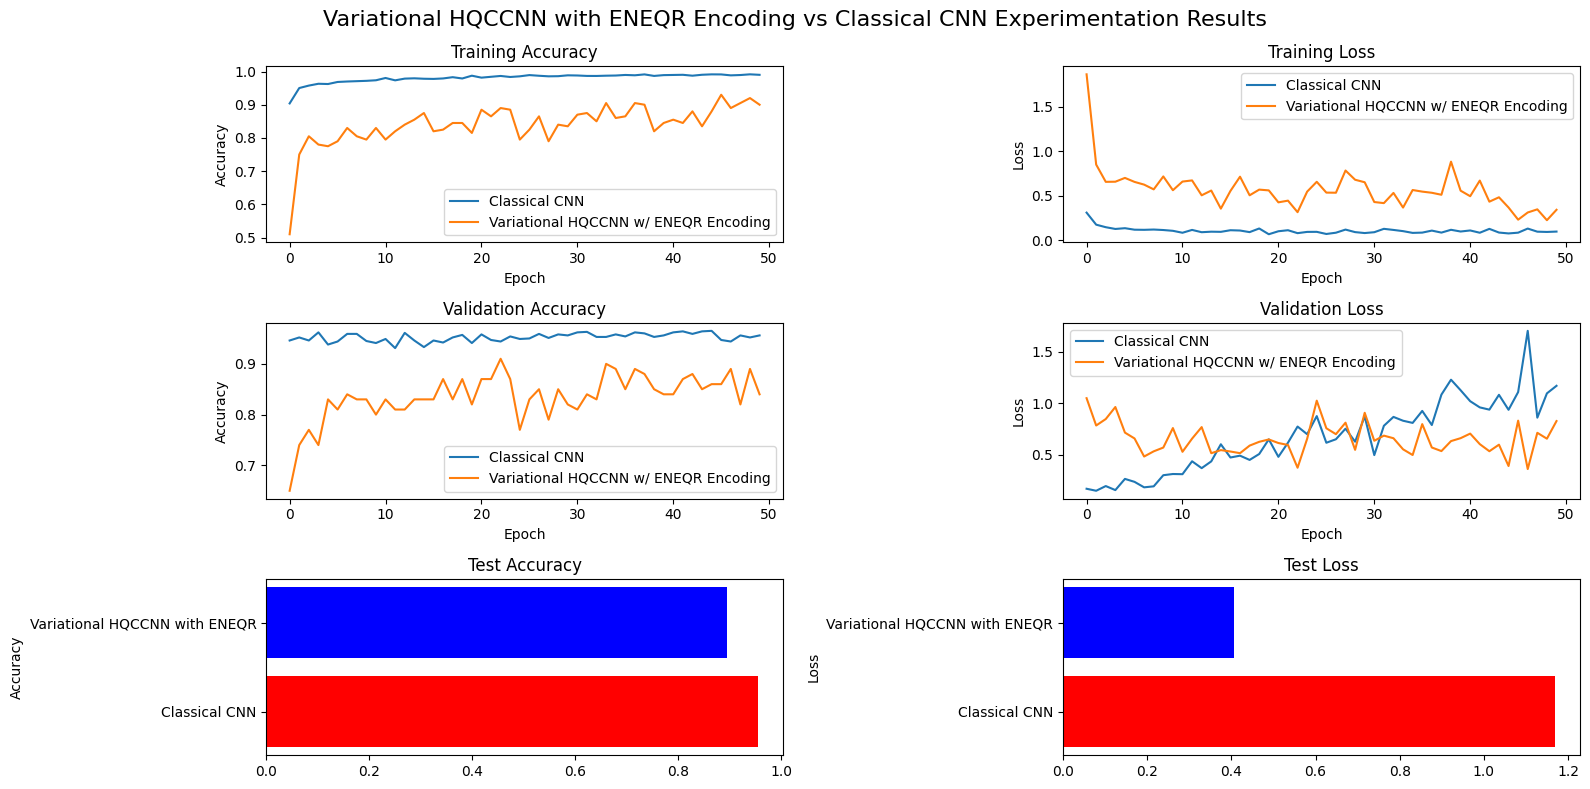

In [180]:
# Extract training accuracy and loss for Classical CNN model
classical_acc = classical_history.history['accuracy']
classical_loss = classical_history.history['loss']

# Extract training accuracy and loss for baseline HQCCNN (threshold_Baseline)
hqccnn_acc = eneqr_Variational['train_acc'].values
hqccnn_loss = eneqr_Variational['train_loss'].values

# Set up the figure and axis
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 8))
fig.suptitle("Variational HQCCNN with ENEQR Encoding vs Classical CNN Experimentation Results", fontsize=16)

# Plot training accuracy
ax1.plot(classical_acc, label='Classical CNN')
ax1.plot(hqccnn_acc, label='Variational HQCCNN w/ ENEQR Encoding')
ax1.set_title('Training Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training loss
ax2.plot(classical_loss, label='Classical CNN')
ax2.plot(hqccnn_loss, label='Variational HQCCNN w/ ENEQR Encoding')
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Extract val accuracy and loss for Classical CNN model
classical_acc = classical_history.history['val_accuracy']
classical_loss = classical_history.history['val_loss']

# Extract training accuracy and loss for baseline HQCCNN (threshold_Baseline)
hqccnn_acc = eneqr_Variational['val_acc'].values
hqccnn_loss = eneqr_Variational['val_loss'].values

# Plot training accuracy
ax3.plot(classical_acc, label='Classical CNN')
ax3.plot(hqccnn_acc, label='Variational HQCCNN w/ ENEQR Encoding')
ax3.set_title('Validation Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot training loss
ax4.plot(classical_loss, label='Classical CNN')
ax4.plot(hqccnn_loss, label='Variational HQCCNN w/ ENEQR Encoding')
ax4.set_title('Validation Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()


# Test the Classical CNN model
test_loss, test_acc = Classical_CNN_model.evaluate(test_images, test_labels, verbose=2)

# Extract training accuracy and loss for baseline HQCCNN (threshold_Baseline)
hqccnn_acc = test_eneqr_Variational['test_acc'].values
hqccnn_loss = test_eneqr_Variational['test_loss'].values
print(test_loss, test_acc)
print(hqccnn_acc, hqccnn_loss)

# Extract test accuracy and loss for Classical CNN model
classical_test_acc = [test_acc]  # Convert to a list
classical_test_loss = [test_loss]  # Convert to a list

# Extract test accuracy and loss for HQCCNN model
hqccnn_test_acc = [hqccnn_acc[0]]  # Convert to a list
hqccnn_test_loss = [hqccnn_loss[0]]  # Convert to a list


# Plot test accuracy
ax5.barh(['Classical CNN', 'Variational HQCCNN with ENEQR'], [classical_test_acc[0], hqccnn_test_acc[0]], color=['r', 'b'])
ax5.set_title('Test Accuracy')
ax5.set_ylabel('Accuracy')

# Plot test loss
ax6.barh(['Classical CNN', 'Variational HQCCNN with ENEQR'], [classical_test_loss[0], hqccnn_test_loss[0]], color=['r', 'b'])
ax6.set_title('Test Loss')
ax6.set_ylabel('Loss')


# Adjust layout and display the figure
plt.tight_layout()
fig.savefig(plot_path + "Variational HQCCNN with ENEQR Encoding vs Classical CNN.png")